In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import itertools

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import importlib

import analysis_functions

In [89]:
dataDir='.'
simDataDir='/'.join([dataDir,'test_multiReplica_MD_table'])
simDataFilename='interrior_data_table.csv'
simDataFilePath='/'.join([simDataDir,simDataFilename])
simData=pd.read_csv(simDataFilePath)
simData.head()

,Window,Rep,Time,Rst07_Z,Rst08_Z,X_Index
0,1,1,0,114.462,3.867,1
1,1,1,500,114.163,4.161,1
2,1,1,1000,113.875,4.452,1
3,1,1,1500,114.027,4.310,1
4,1,1,2000,113.790,4.512,1


In [90]:
print(simData.X_Index.unique(),
      '\n',
      simData.Window.unique())
maxWin=simData['Window'].max()
minWin=simData['Window'].min()
simData['X_Index']=simData['X_Index'].map(
        lambda x: np.clip(x,minWin,maxWin)-minWin)
simData['Window']=simData['Window']-minWin
print('--- --- ---')
print(simData.X_Index.unique(),
      '\n',
      simData.Window.unique())

[ 1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
--- --- ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]


In [91]:
testWin=0
testRep=1
tempDat=simData[(simData['Window']==testWin) & \
        (simData['Rep']==testRep)]
tempDat.head()

,Window,Rep,Time,Rst07_Z,Rst08_Z,X_Index
0,0,1,0,114.462,3.867,0
1,0,1,500,114.163,4.161,0
2,0,1,1000,113.875,4.452,0
3,0,1,1500,114.027,4.310,0
4,0,1,2000,113.790,4.512,0


In [92]:
tempCols=[]
tempCols.append('Window')
tempCols.append(None)

In [ ]:
importlib.reload(analysis_functions)
analysis_functions.compute_bin_escape_counts(
    testWin,tempDat['X_Index'],
)

In [ ]:
importlib.reload(analysis_functions)
simGroups=simData.groupby(['Window','Rep'])

for simGroup in simGroups:
    groupWin,groupRep=simGroup[0]
    print('groupWin:',groupWin,'; groupRep:',groupRep,
          '\n\tescapeData:',
          analysis_functions.compute_bin_escape_counts(
              groupWin,simGroup[1]['X_Index']),
          '\n--- --- ---')

In [93]:
importlib.reload(analysis_functions)

winGroups=simData.groupby(['Window'])

binSet=np.sort(np.unique(np.concatenate([
    simData['Window'].unique(),
    simData['X_Index'].unique()
])))
nBins=len(binSet)
binMap={}
for iBin,binName in enumerate(binSet):
    binMap[binName]=iBin

escapeMat=sp.sparse.lil_matrix((nBins,nBins))
countArray=np.zeros(nBins,dtype=int)

for winGroup in winGroups:
    groupWin=winGroup[0]
    iWin=binMap[groupWin]
    print('Window:',groupWin)
    repGroups=winGroup[1].groupby(['Rep'])
    print('---')
    for repGroup in repGroups:
        groupRep=repGroup[0]
        print('Rep:',groupRep)
        repEscapeData=analysis_functions.compute_bin_escape_counts(
                      groupWin,repGroup[1]['X_Index'],
                      binSet=binSet,
                      giveBinVec=True,
                      giveDeltaVal=True,
                      giveBinT=True)
        print('\tescapeData:',
              repEscapeData,
              '\n---')
        countArray[iWin]+=repEscapeData['count']
        for escapeBinName,escapeCount in \
            zip(repEscapeData['escapes'][0],
                repEscapeData['escapes'][1]):
            iEscapeBin=binMap[escapeBinName]
            escapeMat[iWin,iEscapeBin]+=escapeCount
    escapeMat[iWin,:]=escapeMat[iWin,:]/countArray[iWin]
    escapeMat[iWin,iWin]=1-np.sum(escapeMat[iWin,:])
    print('--- --- ---')

escapeMat=escapeMat.tocsr()
print('countArray:',countArray)
print('escapeMat:',escapeMat)


Window: 0
---
Rep: 1
	escapeData: {'count': 14912, 'escapes': (array([1]), array([434])), 'binVec': array([1, 1, 1, ..., 1, 1, 1]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
--- --- ---
Window: 1
---
Rep: 1
	escapeData: {'count': 12850, 'escapes': (array([0, 2]), array([284, 416])), 'binVec': array([0, 2, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 3, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 2
	escapeData: {'count': 12844, 'escapes': (array([0, 2]), array([256, 408])), 'binVec': array([0, 0, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 3
	escapeData: {'count': 14819, 'escapes': (array([0, 2]), array([327, 555])), 'binVec': array([0, 0, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 3, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 4
	escapeData: {'count': 12869, 'escapes': (array([0, 2]), array([315, 362])), 'binVec': array([0, 2, 2, ..., 2, 1, 2]), 'binT': array([0, 0, 0, ..., 0, 1, 0]), 'deltaVal': 1} 
---
Rep: 5
	escapeData: {'count': 8924, 'e

Rep: 1
	escapeData: {'count': 39365, 'escapes': (array([23, 25]), array([1360, 1152])), 'binVec': array([25, 25, 25, ..., 25, 25, 25]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
--- --- ---
Window: 25
---
Rep: 1
	escapeData: {'count': 17346, 'escapes': (array([24, 26]), array([1525,  157])), 'binVec': array([26, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 2
	escapeData: {'count': 12913, 'escapes': (array([24, 26]), array([418,  54])), 'binVec': array([26, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 3
	escapeData: {'count': 17788, 'escapes': (array([24, 26]), array([348, 414])), 'binVec': array([26, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 4
	escapeData: {'count': 12656, 'escapes': (array([24, 26]), array([483, 465])), 'binVec': array([ 0, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---

In [94]:
import seaborn as sns
import networkx as nwx

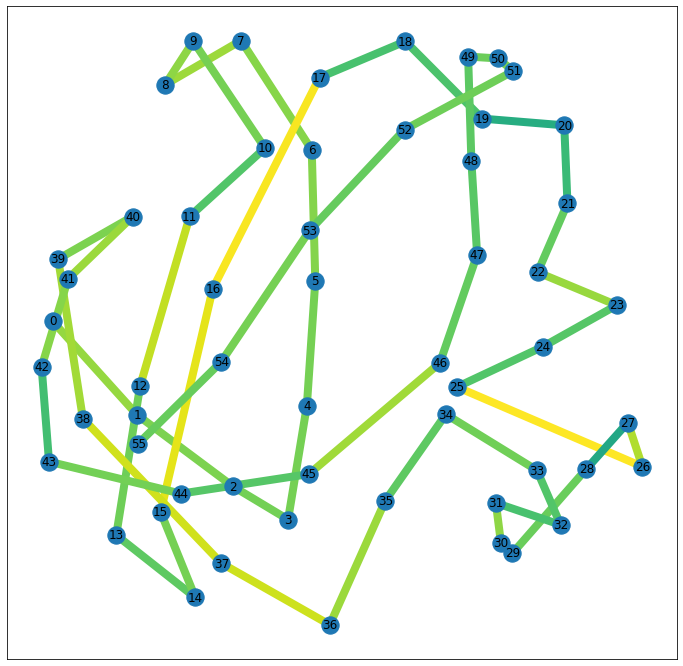

In [95]:
plt.figure(figsize=(12,12))
escapeNet=nwx.from_scipy_sparse_matrix(escapeMat)
edgeWeights=[-np.log(escapeNet.get_edge_data(*edgeTuple)['weight']) for edgeTuple in list(escapeNet.edges)]
nwx.draw_networkx(escapeNet,with_labels=True,
                  edge_color=edgeWeights,
                  width=8)
plt.show()

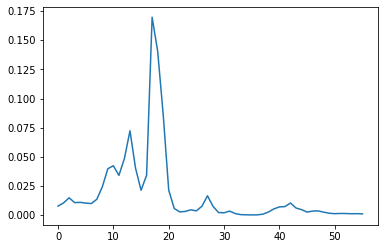

array([0.00792609, 0.01063189, 0.01499295, 0.01087963, 0.01110518,
       0.01047639, 0.01006131, 0.01371619, 0.02436673, 0.03994042,
       0.04245106, 0.03420104, 0.04887149, 0.0724319 , 0.0404929 ,
       0.02147933, 0.03431469, 0.16973767, 0.14073008, 0.08650911,
       0.02157374, 0.00583361, 0.00291758, 0.00334786, 0.00470758,
       0.00383332, 0.00777511, 0.0167279 , 0.00776236, 0.00239321,
       0.00213933, 0.00361457, 0.00151375, 0.00059213, 0.00045018,
       0.00034259, 0.0003964 , 0.00095784, 0.00276862, 0.00548726,
       0.00719951, 0.00747012, 0.01055295, 0.00626554, 0.00485859,
       0.00276046, 0.00362344, 0.00378118, 0.00270792, 0.00178114,
       0.00141669, 0.00158763, 0.00153221, 0.00135933, 0.00142134,
       0.00123097])

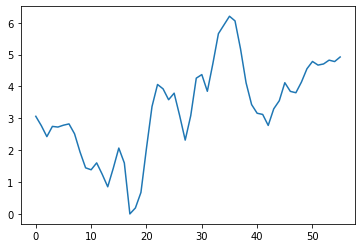

In [96]:
escapeEig=np.linalg.eig(escapeMat.todense().T)
si=np.argsort(1-escapeEig[0])
piVec=np.array(escapeEig[1])[:,si[0]]
piVec=piVec/np.sum(piVec)
plt.plot(piVec)
plt.show()
testVec=-np.log(piVec)
testVec=testVec-np.min(testVec)
plt.plot(testVec)
piVec

In [97]:
importlib.reload(analysis_functions)

escapeDataDict=analysis_functions.analyze_indexed_milestoning_escapes(
    milestoneData=simData,windowColumn='Window',xIndexColumn='X_Index',
    repColumn='Rep',groupingColumn=None,
    giveEscapeMats=True,giveCounts=True,
    giveBins=True,giveBinMaps=True,
    giveCountsMat=True)
escapeDataDict

/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  binInd,xIndSeries,giveWorkingArrays=True)


Group: 0
	Window: 0 (iWin =  0 )
		Rep: 1
		count: 14912 escapes: (array([1]), array([434]))
		---
	--- ---
	Window: 1 (iWin =  1 )
		Rep: 1
		count: 12850 escapes: (array([0, 2]), array([284, 416]))
		---
		Rep: 2
		count: 12844 escapes: (array([0, 2]), array([256, 408]))
		---
		Rep: 3
		count: 14819 escapes: (array([0, 2]), array([327, 555]))
		---
		Rep: 4
		count: 12869 escapes: (array([0, 2]), array([315, 362]))
		---
		Rep: 5
		count: 8924 escapes: (array([0, 2]), array([181, 314]))
		---
		Rep: 6
		count: 3957 escapes: (array([0, 2]), array([ 98, 108]))
		---
		Rep: 7
		count: 14992 escapes: (array([0, 2]), array([302, 800]))
		---
	--- ---
	Window: 2 (iWin =  2 )
		Rep: 1
		count: 24750 escapes: (array([1, 3]), array([640, 492]))
		---
	--- ---
	Window: 3 (iWin =  3 )
		Rep: 1
		count: 4928 escapes: (array([2, 4]), array([135, 136]))
		---
	--- ---
	Window: 4 (iWin =  4 )
		Rep: 1
		count: 24707 escapes: (array([3, 5]), array([668, 633]))
		---
	--- ---
	Window: 5 (iWin =  5 )

		count: 13800 escapes: (array([31, 33]), array([542, 195]))
		---
	--- ---
	Window: 33 (iWin =  33 )
		Rep: 1
		count: 51185 escapes: (array([32, 34]), array([1849, 1093]))
		---
	--- ---
	Window: 34 (iWin =  34 )
		Rep: 1
		count: 28625 escapes: (array([33, 35]), array([804, 708]))
		---
	--- ---
	Window: 35 (iWin =  35 )
		Rep: 1
		count: 8892 escapes: (array([34, 36]), array([289, 213]))
		---
	--- ---
	Window: 36 (iWin =  36 )
		Rep: 1
		count: 8888 escapes: (array([35, 37]), array([184, 320]))
		---
	--- ---
	Window: 37 (iWin =  37 )
		Rep: 1
		count: 8859 escapes: (array([36, 38]), array([132, 375]))
		---
	--- ---
	Window: 38 (iWin =  38 )
		Rep: 1
		count: 10752 escapes: (array([37, 39]), array([ 45, 747]))
		---
		Rep: 2
		count: 10887 escapes: (array([37, 39]), array([195, 285]))
		---
		Rep: 3
		count: 10951 escapes: (array([37, 39]), array([246,  24]))
		---
		Rep: 4
		count: 10807 escapes: (array([37, 39]), array([122, 565]))
		---
		Rep: 5
		count: 10821 escapes: (array(

{0: {'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55]),
  'binMap': {0: 0,
   1: 1,
   2: 2,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9,
   10: 10,
   11: 11,
   12: 12,
   13: 13,
   14: 14,
   15: 15,
   16: 16,
   17: 17,
   18: 18,
   19: 19,
   20: 20,
   21: 21,
   22: 22,
   23: 23,
   24: 24,
   25: 25,
   26: 26,
   27: 27,
   28: 28,
   29: 29,
   30: 30,
   31: 31,
   32: 32,
   33: 33,
   34: 34,
   35: 35,
   36: 36,
   37: 37,
   38: 38,
   39: 39,
   40: 40,
   41: 41,
   42: 42,
   43: 43,
   44: 44,
   45: 45,
   46: 46,
   47: 47,
   48: 48,
   49: 49,
   50: 50,
   51: 51,
   52: 52,
   53: 53,
   54: 54,
   55: 55},
  'escapeMatrix': <56x56 sparse matrix of type '<class 'numpy.float64'>'
  	with 166 stored elements in LInked List form

In [103]:
print(escapeDataDict[0]['escapeMatrix'])

  (0, 0)	0.9708959227467812
  (0, 1)	0.029104077253218882
  (1, 0)	0.021697126330687343
  (1, 1)	0.9418374253892068
  (1, 2)	0.03646544828010584
  (2, 1)	0.02585858585858586
  (2, 2)	0.9542626262626263
  (2, 3)	0.019878787878787878
  (3, 2)	0.02739448051948052
  (3, 3)	0.9450081168831169
  (3, 4)	0.027597402597402596
  (4, 3)	0.02703687214149836
  (4, 4)	0.9473428582992675
  (4, 5)	0.025620269559234226
  (5, 4)	0.027158001009591117
  (5, 5)	0.9493185259969712
  (5, 6)	0.02352347299343766
  (6, 5)	0.024493927125506073
  (6, 6)	0.9426113360323887
  (6, 7)	0.03289473684210526
  (7, 6)	0.024129461060540383
  (7, 7)	0.939727950131071
  (7, 8)	0.03614258880838855
  (8, 7)	0.020344899447744088
  (8, 8)	0.9424559758257789
  (8, 9)	0.037199124726477024
  (9, 8)	0.022694322830689728
  (9, 9)	0.9483241225866648
  (9, 10)	0.02898155458264552
  (10, 9)	0.02726753383722974
  (10, 10)	0.9438609597468799
  (10, 11)	0.028871506415890313
  (11, 10)	0.0358359286992247
  (11, 11)	0.9412099927108872
  (11,

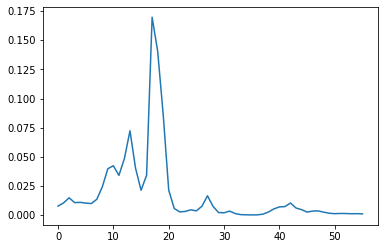

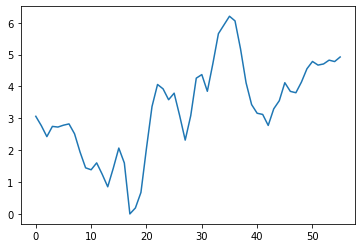

In [98]:
escapeDataDict[0]['piVector']
plt.plot(escapeDataDict[0]['piVector'])
plt.show()
tempVec=-np.log(escapeDataDict[0]['piVector'])
tempVec=tempVec-np.min(tempVec)
plt.plot(tempVec)
plt.show()

In [99]:
runVec=binT[np.nonzero(binC[1:]+binT)] 
                    runList=np.array([[int(j[0]),len(j)] for j in \
                                      [list(g) for k,g in itertools.groupby(runVec)]])
                    for iRun,run in enumerate(runList[1:]):
                        if run[0]==0:
                            rMat[iVal,np.min([runList[iRun,0]-1,xbin])]+=run[1]

IndentationError: unexpected indent (<ipython-input-99-33dbe04155c8>, line 2)

In [43]:
[list(g) for k,g in itertools.groupby([1,1,1,2,0,0,0,1,1,1,1,2,0,0])]

[[1, 1, 1], [2], [0, 0, 0], [1, 1, 1, 1], [2], [0, 0]]

In [100]:
centerBin=2

testVec=np.array([2,2,2,1,0,0,0,0,2,2,3,0,0,2,3,2,3,0,2,1,0,2,1,2,1,0,0,2])
print('testVec:',testVec)
testRuns=[list(g) for k,g in itertools.groupby(testVec)]
print('testRuns:',testRuns)

runPairs=[[run[0],len(run)] for run in testRuns]
print('runPairs:',runPairs)

lastEscape=0
reentriesList=[]
for runPair in runPairs:
    if runPair[0]==0:
        reentriesList.append([0]*runPair[1])
    elif runPair[0]==centerBin:
        reentriesList.append([lastEscape]*runPair[1])
    else:
        lastEscape=runPair[0]
        reentriesList.append([0]*runPair[1])
print('reentriesList:',reentriesList)
reentryVec=np.concatenate(reentriesList)
print('reentryVec:',reentryVec)
print('testVec:   ',testVec)

testVec: [2 2 2 1 0 0 0 0 2 2 3 0 0 2 3 2 3 0 2 1 0 2 1 2 1 0 0 2]
testRuns: [[2, 2, 2], [1], [0, 0, 0, 0], [2, 2], [3], [0, 0], [2], [3], [2], [3], [0], [2], [1], [0], [2], [1], [2], [1], [0, 0], [2]]
runPairs: [[2, 3], [1, 1], [0, 4], [2, 2], [3, 1], [0, 2], [2, 1], [3, 1], [2, 1], [3, 1], [0, 1], [2, 1], [1, 1], [0, 1], [2, 1], [1, 1], [2, 1], [1, 1], [0, 2], [2, 1]]
reentriesList: [[0, 0, 0], [0], [0, 0, 0, 0], [1, 1], [0], [0, 0], [3], [0], [3], [0], [0], [3], [0], [0], [1], [0], [1], [0], [0, 0], [1]]
reentryVec: [0 0 0 0 0 0 0 0 1 1 0 0 0 3 0 3 0 0 3 0 0 1 0 1 0 0 0 1]
testVec:    [2 2 2 1 0 0 0 0 2 2 3 0 0 2 3 2 3 0 2 1 0 2 1 2 1 0 0 2]


In [101]:
importlib.reload(analysis_functions)

testVec=np.array([2,2,2,1,1,1,1,1,2,2,3,3,3,3,2,1,2,3,3,3,2,3,2,3,3,2,1,1,2,1,2,1,1,1,2])
testReentryData=analysis_functions.compute_reentry_vector(binInd=2,xIndSeries=testVec,
                           binSet=[1,2,3],giveBins=True,
                           giveDeltaVal=True)
print('testReentryData:',testReentryData)
print('---')
print('testVec:   ',testVec)
print('reentryVec:',testReentryData[0]-testReentryData[1]['deltaVal'])

testReentryData: [array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 1, 1, 0, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 1, 1, 1, 1, 0, 0, 1, 1]), {'bins': [1, 2, 3], 'deltaVal': 0}]
---
testVec:    [2 2 2 1 1 1 1 1 2 2 3 3 3 3 2 1 2 3 3 3 2 3 2 3 3 2 1 1 2 1 2 1 1 1 2]
reentryVec: [0 0 0 0 0 0 0 1 1 1 0 0 0 3 3 1 1 0 0 3 3 3 3 0 3 3 0 1 1 1 1 0 0 1 1]


In [102]:
importlib.reload(analysis_functions)

offset=-1
testVec=np.array([2,2,2,1,1,1,1,1,2,2,3,3,3,3,2,1,2,3,3,3,2,3,2,3,3,2,1,1,2,1,2,1,1,1,2])+offset
testReentryData=analysis_functions.compute_reentry_counts(binInd=2+offset,xIndSeries=testVec,
                           binSet=[0,1,2,3,4,5],giveBins=True,
                           giveDeltaVal=True,giveReentryVec=True)
print('testReentryData:',testReentryData)
print('---')
print('testVec:   ',testVec)
print('reentryVec:',testReentryData['reentryVec']-testReentryData['deltaVal'])

testReentryData: {'count': 19, 'reentries': (array([0, 2]), array([11,  8])), 'binSet': [0, 1, 2, 3, 4, 5], 'reentryVec': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 1, 1, 0, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 1, 1, 1, 1, 0, 0, 1, 1]), 'deltaVal': 1}
---
testVec:    [1 1 1 0 0 0 0 0 1 1 2 2 2 2 1 0 1 2 2 2 1 2 1 2 2 1 0 0 1 0 1 0 0 0 1]
reentryVec: [-1 -1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1  2  2  0  0 -1 -1  2  2  2  2 -1
  2  2 -1  0  0  0  0 -1 -1  0  0]


In [72]:
simData.head()

,Window,Rep,Time,Rst07_Z,Rst08_Z,X_Index
0,0,1,0,114.462,3.867,0
1,0,1,500,114.163,4.161,0
2,0,1,1000,113.875,4.452,0
3,0,1,1500,114.027,4.310,0
4,0,1,2000,113.790,4.512,0


In [103]:
importlib.reload(analysis_functions)

analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
    simData,
    windowColumn='Window',xIndexColumn='X_Index',
    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
analysisFrame.head()

/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:421: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:431: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  groupingCol=groupingColumn
/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

--- --- --- Grouping Name: 0 --- --- ---
	binSet: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] ; deltaVal: 1
	--- --- Window Name: 0 --- ---
		--- Replica Name: 1 

/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  windowGroups=groupDataFrame.groupby(windowColumn)
/Users/wbotellosmith/Documents/Milestoning_Analysis/analysis_functions.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  binMap={}


---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 1 2 3 4 5 6 7 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 1 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 11 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 12 -

,Window,X_Index,Group,Rep,Frame,Escape_Vector,Reentry_Vector
0,0,0,0,1,0,0,-1
1,0,0,0,1,1,0,-1
2,0,0,0,1,2,0,-1
3,0,0,0,1,3,0,-1
4,0,0,0,1,4,0,-1


In [104]:
print("Escape_Vector Values:",
      analysisFrame['Reentry_Vector'].unique(),
      "\n---\nReentry_Vector Valus:",
      analysisFrame['Reentry_Vector'].unique())

Escape_Vector Values: [-1  1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55] 
---
Reentry_Vector Valus: [-1  1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55]


testEscapeData: {'piVec': array([0.00792609, 0.01063189, 0.01499295, 0.01087963, 0.01110518,
       0.01047639, 0.01006131, 0.01371619, 0.02436673, 0.03994042,
       0.04245106, 0.03420104, 0.04887149, 0.0724319 , 0.0404929 ,
       0.02147933, 0.03431469, 0.16973767, 0.14073008, 0.08650911,
       0.02157374, 0.00583361, 0.00291758, 0.00334786, 0.00470758,
       0.00383332, 0.00777511, 0.0167279 , 0.00776236, 0.00239321,
       0.00213933, 0.00361457, 0.00151375, 0.00059213, 0.00045018,
       0.00034259, 0.0003964 , 0.00095784, 0.00276862, 0.00548726,
       0.00719951, 0.00747012, 0.01055295, 0.00626554, 0.00485859,
       0.00276046, 0.00362344, 0.00378118, 0.00270792, 0.00178114,
       0.00141669, 0.00158763, 0.00153221, 0.00135933, 0.00142134,
       0.00123097]), 'escapeMat': <56x56 sparse matrix of type '<class 'numpy.float64'>'
	with 166 stored elements in LInked List format>, 'counts': array([ 14912,  81255,  24750,   4928,  24707,   9905,   9880,  48447,
        38388,  6

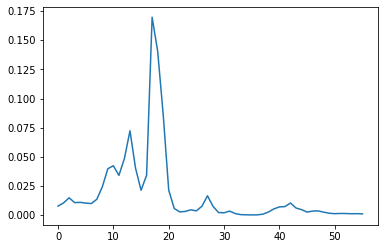

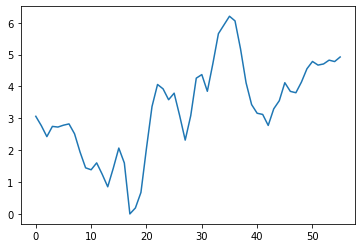

In [106]:
importlib.reload(analysis_functions)

binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Index'].unique()
])))

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
print('testEscapeData:',testEscapeData)
plt.plot(testEscapeData['piVec'])
plt.show()
tempVec=-np.log(testEscapeData['piVec'])
tempVec=tempVec-np.min(tempVec)
plt.plot(tempVec)
plt.show()

In [156]:
print(testEscapeData['escapeMat'])
print('--- --- ---')
print(escapeDataDict[0]['escapeMatrix'])

  (0, 0)	0.9708959227467812
  (0, 1)	0.029104077253218882
  (1, 0)	0.021697126330687343
  (1, 1)	0.9418374253892068
  (1, 2)	0.03646544828010584
  (2, 1)	0.02585858585858586
  (2, 2)	0.9542626262626263
  (2, 3)	0.019878787878787878
  (3, 2)	0.02739448051948052
  (3, 3)	0.9450081168831169
  (3, 4)	0.027597402597402596
  (4, 3)	0.02703687214149836
  (4, 4)	0.9473428582992675
  (4, 5)	0.025620269559234226
  (5, 4)	0.027158001009591117
  (5, 5)	0.9493185259969712
  (5, 6)	0.02352347299343766
  (6, 5)	0.024493927125506073
  (6, 6)	0.9426113360323887
  (6, 7)	0.03289473684210526
  (7, 6)	0.024129461060540383
  (7, 7)	0.939727950131071
  (7, 8)	0.03614258880838855
  (8, 7)	0.020344899447744088
  (8, 8)	0.9424559758257789
  (8, 9)	0.037199124726477024
  (9, 8)	0.022694322830689728
  (9, 9)	0.9483241225866648
  (9, 10)	0.02898155458264552
  (10, 9)	0.02726753383722974
  (10, 10)	0.9438609597468799
  (10, 11)	0.028871506415890313
  (11, 10)	0.0358359286992247
  (11, 11)	0.9412099927108872
  (11,

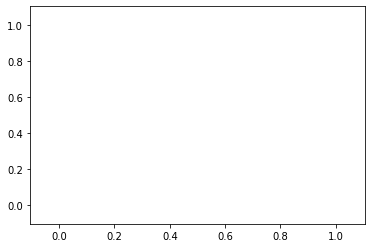

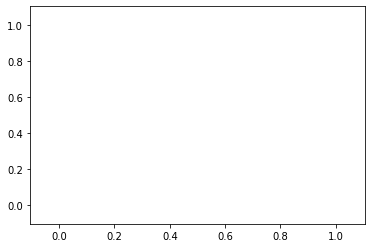

In [157]:
delMat=(testEscapeData['escapeMat'].tocsr()-\
          escapeDataDict[0]['escapeMatrix'].tocsr())
print(delMat)
delMatDense=delMat.todense()
sns.distplot(delMatDense[np.nonzero(delMatDense)],bins=100)
plt.show()
sns.distplot(np.log10(delMatDense[np.nonzero(delMatDense)]/
             testEscapeData['escapeMat'].todense()[np.nonzero(delMatDense)]),
             bins=100)
plt.show()

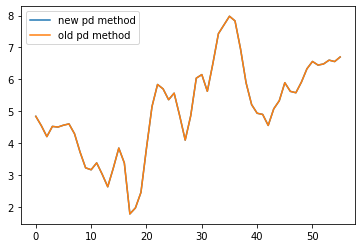

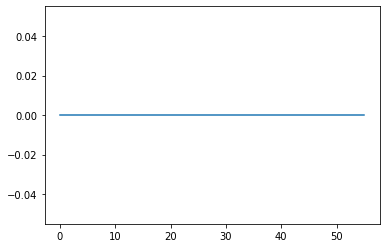

In [168]:
tempVec1=-np.log(testEscapeData['piVec'])
#tempVec1=tempVec1-np.min(tempVec1)
plt.plot(tempVec1,label='new pd method')
tempVec2=-np.log(escapeDataDict[0]['piVector'])
#tempVec2=tempVec2-np.min(tempVec2)
plt.plot(tempVec2,label='old pd method')
plt.legend()
plt.show()
plt.plot(tempVec2-tempVec1)
plt.show()

In [169]:
np.unique(tempVec2-tempVec1)

array([0.])

In [160]:
escapeDataDict[0].keys()

dict_keys(['bins', 'binMap', 'escapeMatrix', 'piVector', 'counts', 'countsMat'])

In [161]:
countsMat1=escapeDataDict[0]['countsMat']
countsMat2=testEscapeData['countsMat']
delCounts=countsMat2-countsMat1
print(delCounts)

  (0, 0)	-434.0
  (1, 1)	-4726.0
  (2, 2)	-1132.0
  (3, 3)	-271.0
  (4, 4)	-1301.0
  (5, 5)	-502.0
  (6, 6)	-567.0
  (7, 7)	-2920.0
  (8, 8)	-2209.0
  (9, 9)	-3600.0
  (10, 10)	-2555.0
  (11, 11)	-4436.0
  (12, 12)	-4068.0
  (13, 13)	-3629.0
  (14, 14)	-1798.0
  (15, 15)	-2518.0
  (16, 16)	-1249.0
  (17, 17)	-1244.0
  (18, 18)	-2335.0
  (19, 19)	-5783.0
  (20, 20)	-17782.0
  (21, 21)	-2653.0
  (22, 22)	-1311.0
  (23, 23)	-1296.0
  (24, 24)	-2512.0
  :	:
  (31, 31)	-1126.0
  (32, 32)	-737.0
  (33, 33)	-2942.0
  (34, 34)	-1512.0
  (35, 35)	-502.0
  (36, 36)	-504.0
  (37, 37)	-507.0
  (38, 38)	-2901.0
  (39, 39)	-733.0
  (40, 40)	-882.0
  (41, 41)	-1294.0
  (42, 42)	-433.0
  (43, 43)	-558.0
  (44, 44)	-420.0
  (45, 45)	-543.0
  (46, 46)	-468.0
  (47, 47)	-1041.0
  (48, 48)	-1600.0
  (49, 49)	-779.0
  (50, 50)	-523.0
  (51, 51)	-478.0
  (52, 52)	-2537.0
  (53, 53)	-585.0
  (54, 54)	-525.0
  (55, 55)	-149.0


In [162]:
print(countsMat2)

  (0, 0)	14478.0
  (0, 1)	434.0
  (1, 0)	1763.0
  (1, 1)	76529.0
  (1, 2)	2963.0
  (2, 1)	640.0
  (2, 2)	23618.0
  (2, 3)	492.0
  (3, 2)	135.0
  (3, 3)	4657.0
  (3, 4)	136.0
  (4, 3)	668.0
  (4, 4)	23406.0
  (4, 5)	633.0
  (5, 4)	269.0
  (5, 5)	9403.0
  (5, 6)	233.0
  (6, 5)	242.0
  (6, 6)	9313.0
  (6, 7)	325.0
  (7, 6)	1169.0
  (7, 7)	45527.0
  (7, 8)	1751.0
  (8, 7)	781.0
  (8, 8)	36179.0
  (8, 9)	1428.0
  (9, 8)	1581.0
  (9, 9)	66065.0
  (9, 10)	2019.0
  (10, 9)	1241.0
  (10, 10)	42957.0
  (10, 11)	1314.0
  (11, 10)	2704.0
  (11, 11)	71019.0
  (11, 12)	1732.0
  (12, 11)	1125.0
  (12, 12)	65966.0
  (12, 13)	2943.0
  (13, 12)	2212.0
  (13, 13)	74386.0
  (13, 14)	1417.0
  (14, 13)	1250.0
  (14, 14)	36676.0
  (14, 15)	548.0
  (15, 14)	1432.0
  (15, 15)	50812.0
  (15, 16)	1086.0
  (16, 15)	237.0
  (16, 16)	17344.0
  (16, 17)	1012.0
  (17, 16)	316.0
  (17, 17)	27474.0
  (17, 18)	928.0
  (18, 17)	1460.0
  (18, 18)	35125.0
  (18, 19)	875.0
  (19, 18)	4197.0
  (19, 19)	104669.0
  (19, 20)	15

In [163]:
print(countsMat1)

  (0, 0)	14912.0
  (0, 1)	434.0
  (1, 0)	1763.0
  (1, 1)	81255.0
  (1, 2)	2963.0
  (2, 1)	640.0
  (2, 2)	24750.0
  (2, 3)	492.0
  (3, 2)	135.0
  (3, 3)	4928.0
  (3, 4)	136.0
  (4, 3)	668.0
  (4, 4)	24707.0
  (4, 5)	633.0
  (5, 4)	269.0
  (5, 5)	9905.0
  (5, 6)	233.0
  (6, 5)	242.0
  (6, 6)	9880.0
  (6, 7)	325.0
  (7, 6)	1169.0
  (7, 7)	48447.0
  (7, 8)	1751.0
  (8, 7)	781.0
  (8, 8)	38388.0
  (8, 9)	1428.0
  (9, 8)	1581.0
  (9, 9)	69665.0
  (9, 10)	2019.0
  (10, 9)	1241.0
  (10, 10)	45512.0
  (10, 11)	1314.0
  (11, 10)	2704.0
  (11, 11)	75455.0
  (11, 12)	1732.0
  (12, 11)	1125.0
  (12, 12)	70034.0
  (12, 13)	2943.0
  (13, 12)	2212.0
  (13, 13)	78015.0
  (13, 14)	1417.0
  (14, 13)	1250.0
  (14, 14)	38474.0
  (14, 15)	548.0
  (15, 14)	1432.0
  (15, 15)	53330.0
  (15, 16)	1086.0
  (16, 15)	237.0
  (16, 16)	18593.0
  (16, 17)	1012.0
  (17, 16)	316.0
  (17, 17)	28718.0
  (17, 18)	928.0
  (18, 17)	1460.0
  (18, 18)	37460.0
  (18, 19)	875.0
  (19, 18)	4197.0
  (19, 19)	110452.0
  (19, 20)	15

In [164]:
for windowGroup in analysisFrame.groupby(['Window']):
    print(windowGroup[1].head())

   Window  X_Index  Group  Rep  Escape_Vector  Reentry_Vector
0       0        0      0    1              0              -1
1       0        0      0    1              0              -1
2       0        0      0    1              0              -1
3       0        0      0    1              0              -1
4       0        0      0    1              0              -1
       Window  X_Index  Group  Rep  Escape_Vector  Reentry_Vector
15000       1        2      0    1             -1               2
15001       1        1      0    1              1               2
15002       1        1      0    1              1               2
15003       1        2      0    1              2               2
15004       1        1      0    1              1               2
       Window  X_Index  Group  Rep  Escape_Vector  Reentry_Vector
97300       2        2      0    1              2              -1
97301       2        1      0    1              1               1
97302       2        2      0    1

In [170]:
?sp.sparse.lil_matrix

In [177]:
tempN=10
tempMat=np.zeros((tempN,tempN))-1
print(tempMat)
print ('---')
for ii in np.arange(tempN-1):
    for jj in np.arange(ii+1,tempN):
        tempMat[ii,jj]=ii+(tempN-1)*(jj-1)
print(tempMat)
print('---')
tempInds=np.nonzero(tempMat>-1)
tempPairMap=np.array([
    [iPair[0],iPair[1]] for iPair in \
    zip(tempInds[0],tempInds[1])
])
print(tempPairMap)

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
---
[[-1.  0.  9. 18. 27. 36. 45. 54. 63. 72.]
 [-1. -1. 10. 19. 28. 37. 46. 55. 64. 73.]
 [-1. -1. -1. 20. 29. 38. 47. 56. 65. 74.]
 [-1. -1. -1. -1. 30. 39. 48. 57. 66. 75.]
 [-1. -1. -1. -1. -1. 40. 49. 58. 67. 76.]
 [-1. -1. -1. -1. -1. -1. 50. 59. 68. 77.]
 [-1. -1. -1. -1. -1. -1. -1. 60. 69. 78.]
 [-1. -1. -1. -1. -1. -1. -1. -1. 70. 79.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. 80.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
---
[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 3]
 [2 

In [180]:
binAr=np.arange(-1,5)
tempAr=np.array([1,3,6,7,1,2,0,-2,-2,-2,1,4])
np.isin(tempAr,binAr)

array([ True,  True, False, False,  True,  True,  True, False, False,
       False,  True,  True])

In [88]:
importlib.reload(analysis_functions)

#tempXvec=np.random.randint(low=0,high=8,size=20)
tempXvec=np.array([1,2,1,1,0,3,4,3,3,3,3,4,4,3,3,0,3,3,4,4,3,3,0,0,1,3,6,3,3,3,3,3,2,6,6,7,3,7])
print('tempXvec:',tempXvec)
tempIndCounts=np.unique(tempXvec,return_counts=True)
tempInd=tempIndCounts[0][np.argmax(tempIndCounts[1])]
print('tempInd:',tempInd)
tempBinSet=tempIndCounts[0]
print('tempBinSet:',tempBinSet)
tempBinInfo=analysis_functions.build_bin_mappings(binSet=tempBinSet)
print('tempBinInfo:',tempBinInfo)
tempEdgeInfo=analysis_functions.build_edge_mappings(len(tempBinSet))
print('tempEdgeInfo:',tempEdgeInfo)
tempEscData=analysis_functions.compute_bin_vector(
    binInd=tempInd,xIndSeries=tempXvec,binSet=tempBinSet,giveBins=True,giveDeltaVal=True)
print('tempEscData:',tempEscData)
tempEscVec=tempEscData[0]-tempEscData[1]['deltaVal']
print('tempEscVec:',tempEscVec)
tempReVecData=analysis_functions.compute_reentry_vector(
    binInd=tempInd,xIndSeries=tempXvec,binSet=tempBinSet,
    giveBins=True,giveDeltaVal=True,verbose=False)
print('tempReVecData',tempReVecData)
tempReVec=tempReVecData[0]-tempReVecData[1]['deltaVal']
print('tempReVec:',tempReVec)
tempComp=np.zeros((len(tempXvec),3))
tempComp[:,0]=tempXvec
tempComp[:,1]=tempEscVec
tempComp[:,2]=tempReVec
print('vecCompare:')
print(tempComp)
tempTransInfo=analysis_functions.compute_bin_edge_transitions(
    binInd=tempInd,escapeVec=tempEscVec[1:],reentryVec=tempReVec[:-1],
    binSet=tempBinSet,edgeMaps=tempEdgeInfo,
    giveBins=False,giveBinMap=False,giveEdgeMaps=False,verbose=True)
print('tempTransInfo:')
for entryKey in tempTransInfo:
    print(entryKey,tempTransInfo[entryKey])

tempXvec: [1 2 1 1 0 3 4 3 3 3 3 4 4 3 3 0 3 3 4 4 3 3 0 0 1 3 6 3 3 3 3 3 2 6 6 7 3
 7]
tempInd: 3
tempBinSet: [0 1 2 3 4 6 7]
tempBinInfo: {'bins': array([0, 1, 2, 3, 4, 6, 7]), 'binSortArr': array([0, 1, 2, 3, 4, 5, 6]), 'binMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6}, 'binSetMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6}}
tempEdgeInfo: {'edgeIndToPair': array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [3, 4],
       [3, 5],
       [3, 6],
       [4, 5],
       [4, 6],
       [5, 6]]), 'edgePairToInd': array([[-1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-1., -1.,  6.,  7.,  8.,  9., 10.],
       [-1., -1., -1., 11., 12., 13., 14.],
       [-1., -1., -1., -1., 15., 16., 17.],
       [-1., -1., -1., -1., -1., 18., 19.],
       [-1., -1., -1., -1., -1., -1., 20.],
       [-1., -1., -1., -1., -1., -1

In [122]:
binSet=np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Index'].unique()
]))
print(binSet)
binInfo=analysis_functions.build_bin_mappings(binSet)
print(binInfo)
edgeInfo=analysis_functions.build_edge_mappings(len(binSet))
print(edgeInfo)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
{'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), 'binSortArr': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), 'binMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38

In [109]:
analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=False,giveCounts=False,
                                     giveCountsMat=False)

array([0.00792609, 0.01063189, 0.01499295, 0.01087963, 0.01110518,
       0.01047639, 0.01006131, 0.01371619, 0.02436673, 0.03994042,
       0.04245106, 0.03420104, 0.04887149, 0.0724319 , 0.0404929 ,
       0.02147933, 0.03431469, 0.16973767, 0.14073008, 0.08650911,
       0.02157374, 0.00583361, 0.00291758, 0.00334786, 0.00470758,
       0.00383332, 0.00777511, 0.0167279 , 0.00776236, 0.00239321,
       0.00213933, 0.00361457, 0.00151375, 0.00059213, 0.00045018,
       0.00034259, 0.0003964 , 0.00095784, 0.00276862, 0.00548726,
       0.00719951, 0.00747012, 0.01055295, 0.00626554, 0.00485859,
       0.00276046, 0.00362344, 0.00378118, 0.00270792, 0.00178114,
       0.00141669, 0.00158763, 0.00153221, 0.00135933, 0.00142134,
       0.00123097])

In [129]:
importlib.reload(analysis_functions)
QdataDict=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=False,giveCounts=False,
                                     giveCountsMat=False)
for entryKey in QdataDict:
    print(entryKey,':',QdataDict[entryKey])

Computing R and N: ( 0 : 1 ) ( 1 : 1 2 3 4 5 6 7 ) ( 2 : 1 ) ( 3 : 1 ) ( 4 : 1 ) ( 5 : 1 ) ( 6 : 1 ) ( 7 : 1 3 4 5 ) ( 8 : 1 ) ( 9 : 1 2 3 4 5 ) ( 10 : 1 2 3 4 5 ) ( 11 : 1 2 3 4 5 ) ( 12 : 1 2 3 4 5 ) ( 13 : 1 2 3 4 5 ) ( 14 : 1 ) ( 15 : 1 ) ( 16 : 1 ) ( 17 : 1 ) ( 18 : 1 2 3 4 ) ( 19 : 1 2 3 4 5 6 7 ) ( 20 : 1 2 3 4 5 6 7 8 9 10 11 ) ( 21 : 1 ) ( 22 : 1 ) ( 23 : 1 ) ( 24 : 1 ) ( 25 : 1 2 3 4 5 6 7 ) ( 26 : 1 ) ( 27 : 1 2 3 4 5 ) ( 28 : 1 2 3 4 5 ) ( 29 : 1 2 3 ) ( 30 : 1 2 ) ( 31 : 1 ) ( 32 : 1 ) ( 33 : 1 ) ( 34 : 1 ) ( 35 : 1 ) ( 36 : 1 ) ( 37 : 1 ) ( 38 : 1 2 3 4 5 ) ( 39 : 1 ) ( 40 : 1 ) ( 41 : 1 ) ( 42 : 1 ) ( 43 : 1 ) ( 44 : 1 ) ( 45 : 1 ) ( 46 : 1 ) ( 47 : 1 ) ( 48 : 1 ) ( 49 : 1 ) ( 50 : 1 ) ( 51 : 1 ) ( 52 : 1 2 3 4 5 6 7 ) ( 53 : 1 ) ( 54 : 1 ) ( 55 : 1 ) 
Rmat :   (0, 1)	3850458.8126480426
  (1, 0)	2158777.749540893
  (1, 2)	3007734.5767611177
  (2, 1)	3964272.3783260807
  (2, 3)	3324028.1059480333
  (3, 2)	2582338.198629966
  (3, 4)	2699326.920014283
  (4, 3)	2641182.82495

In [124]:
Rmat=QdataDict['Rmat']
np.nonzero(Rmat)

(array([ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,
        17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25,
        26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34,
        34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42,
        43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51,
        51, 52, 52, 53, 53, 54, 54, 55], dtype=int32),
 array([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,
         8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16,
        18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26,
        25, 27, 26, 28, 27, 29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 34, 33,
        35, 34, 36, 35, 37, 36, 38, 37, 39, 38, 40, 39, 41, 40, 42, 41, 43,
        42, 44, 43, 45, 44, 46, 45, 47, 46, 48, 47, 49, 48, 50, 49, 51, 50,
        52, 51, 53, 52, 54, 53, 5

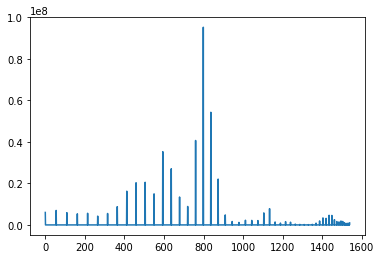


  (0, 55)	0.0052292828424272495
  (55, 0)	0.004534538167880546
  (55, 109)	0.003463715419067341
  (109, 55)	0.00408864718963713
  (109, 162)	0.005633247239054486
  (162, 109)	0.006230120956047842
  (162, 214)	0.004828133141908481
  (214, 162)	0.004638561427213705
  (214, 265)	0.004311075599667234
  (265, 214)	0.005578755825196986
  (265, 315)	0.00677248528760649
  (315, 265)	0.005126414316571029
  (315, 364)	0.0023253623987854657
  (364, 315)	0.001470323514433546
  (364, 412)	0.002980842894688335
  (412, 364)	0.0016146050988433665
  (412, 459)	0.002316207693976131
  (459, 412)	0.0018804947401075123
  (459, 505)	0.00254578043578907
  (505, 459)	0.0024951602944831776
  (505, 550)	0.001201784803301728
  (550, 505)	0.0016208640608231892
  (550, 594)	0.0023139258863932007
  (594, 550)	0.0009799872533552444
  (594, 637)	0.001930200135979508
  (637, 594)	0.0025360511347996763
  (637, 679)	0.0011159025422243017
  (679, 637)	0.0022452382230499827
  (679, 720)	0.0010776548198688026
  (720, 679)

In [146]:
Rmat=QdataDict['Rmat']
ePairToInd=edgeInfo['edgePairToInd']
nEdges=np.sum(ePairToInd>-1)
Ri_vec=np.zeros(nEdges)
Rpairs=np.nonzero(Rmat)
for Rpair in zip(Rpairs[0],Rpairs[1]):
    Redge=ePairToInd[np.min(Rpair),np.max(Rpair)]
    Ri_vec[Redge]+=Rmat[Rpair[0],Rpair[1]]
plt.plot(Ri_vec)
plt.show()
Qmat=sp.sparse.lil_matrix((nEdges,nEdges))
print(Qmat)
for Redge in np.nonzero(Ri_vec)[0]:
    Qmat[Redge,:]=QdataDict['Nmat'][Redge,:]/Ri_vec[Redge]
print(Qmat)

In [150]:
Qnet=nwx.from_scipy_sparse_matrix(Qmat,create_using=nwx.DiGraph)
Qnet.edges(data=True)

OutEdgeDataView([(0, 55, {'weight': 0.0052292828424272495}), (55, 0, {'weight': 0.004534538167880546}), (55, 109, {'weight': 0.003463715419067341}), (109, 55, {'weight': 0.00408864718963713}), (109, 162, {'weight': 0.005633247239054486}), (162, 109, {'weight': 0.006230120956047842}), (162, 214, {'weight': 0.004828133141908481}), (214, 162, {'weight': 0.004638561427213705}), (214, 265, {'weight': 0.004311075599667234}), (265, 214, {'weight': 0.005578755825196986}), (265, 315, {'weight': 0.00677248528760649}), (315, 265, {'weight': 0.005126414316571029}), (315, 364, {'weight': 0.0023253623987854657}), (364, 315, {'weight': 0.001470323514433546}), (364, 412, {'weight': 0.002980842894688335}), (412, 364, {'weight': 0.0016146050988433665}), (412, 459, {'weight': 0.002316207693976131}), (459, 412, {'weight': 0.0018804947401075123}), (459, 505, {'weight': 0.00254578043578907}), (505, 459, {'weight': 0.0024951602944831776}), (505, 550, {'weight': 0.001201784803301728}), (550, 505, {'weight': 0

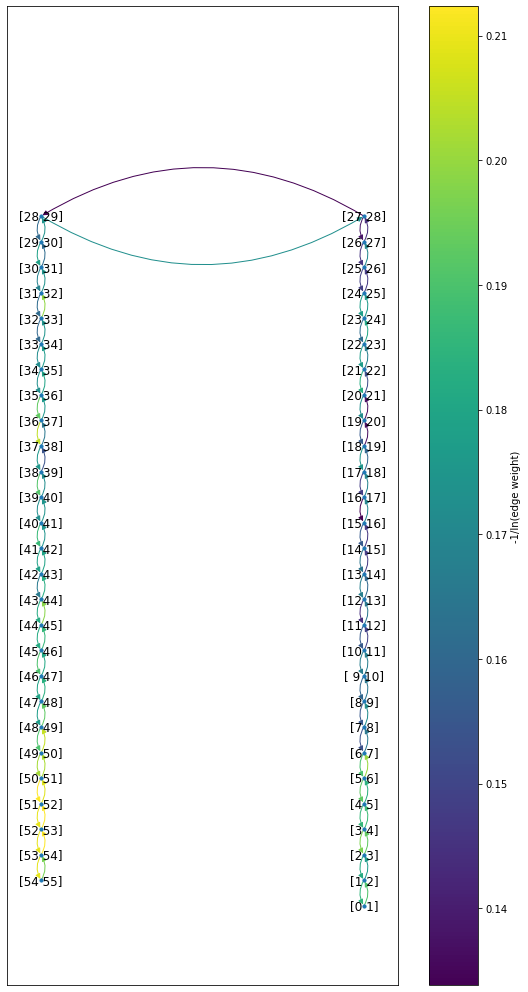

In [284]:
edges,weights = zip(*nwx.get_edge_attributes(Qnet,'weight').items());

eIndToPair=edgeInfo['edgeIndToPair'];

nodeSet=list(np.unique(np.array(edges).flatten()));
nodeLabels={node_i:str(eIndToPair[node_i]) for node_i in nodeSet};

edge_labels=dict([((u,v,),'{:.3f}'.format(1/-np.log(d['weight'])))
             for u,v,d in Qnet.edges(data=True)]);

#pos=nwx.planar_layout(Qnet)

nNodes=len(nodeSet);
nX=int(np.sqrt(nNodes));
pos={nodeInd:np.array([.5-int(iNode/(nNodes/2)),
                       iNode/nNodes if iNode<(nNodes/2) \
                       else 1-iNode/nNodes]) \
                      for iNode,nodeInd in enumerate(nodeSet)};

fig=plt.figure(figsize=(14,18))
edge_colors=1/-np.log(weights)
nwx.draw_networkx(Qnet,pos,node_size=10,
                  nodelist=nodeSet,labels=nodeLabels,
                  edge_labels=edge_labels,
                  connectionstyle='arc3, rad=0.3',
                  edgelist=edges, edge_color=edge_colors,
                  width=1,arrows=True)
cbar=fig.colorbar(
    matplotlib.cm.ScalarMappable(
        norm = matplotlib.colors.Normalize(
            vmin=np.min(edge_colors), vmax=np.max(edge_colors))),
                  fraction=0.46, pad=0.04)
cbar.set_label('-1/ln(edge weight)')
plt.show()

In [268]:
pos

{0: array([0.5, 0.5]),
 55: array([0.5       , 0.48181818]),
 109: array([0.5       , 0.46363636]),
 162: array([0.5       , 0.44545455]),
 214: array([0.5       , 0.42727273]),
 265: array([0.5       , 0.40909091]),
 315: array([0.5       , 0.39090909]),
 364: array([0.5       , 0.37272727]),
 412: array([0.5       , 0.35454545]),
 459: array([0.5       , 0.33636364]),
 505: array([0.5       , 0.31818182]),
 550: array([0.5, 0.3]),
 594: array([0.5       , 0.28181818]),
 637: array([0.5       , 0.26363636]),
 679: array([0.5       , 0.24545455]),
 720: array([0.5       , 0.22727273]),
 760: array([0.5       , 0.20909091]),
 799: array([0.5       , 0.19090909]),
 837: array([0.5       , 0.17272727]),
 874: array([0.5       , 0.15454545]),
 910: array([0.5       , 0.13636364]),
 945: array([0.5       , 0.11818182]),
 979: array([0.5, 0.1]),
 1012: array([0.5       , 0.08181818]),
 1044: array([0.5       , 0.06363636]),
 1075: array([0.5       , 0.04545455]),
 1105: array([0.5       , 0.

In [285]:
print(Qmat)

  (0, 55)	0.0052292828424272495
  (55, 0)	0.004534538167880546
  (55, 109)	0.003463715419067341
  (109, 55)	0.00408864718963713
  (109, 162)	0.005633247239054486
  (162, 109)	0.006230120956047842
  (162, 214)	0.004828133141908481
  (214, 162)	0.004638561427213705
  (214, 265)	0.004311075599667234
  (265, 214)	0.005578755825196986
  (265, 315)	0.00677248528760649
  (315, 265)	0.005126414316571029
  (315, 364)	0.0023253623987854657
  (364, 315)	0.001470323514433546
  (364, 412)	0.002980842894688335
  (412, 364)	0.0016146050988433665
  (412, 459)	0.002316207693976131
  (459, 412)	0.0018804947401075123
  (459, 505)	0.00254578043578907
  (505, 459)	0.0024951602944831776
  (505, 550)	0.001201784803301728
  (550, 505)	0.0016208640608231892
  (550, 594)	0.0023139258863932007
  (594, 550)	0.0009799872533552444
  (594, 637)	0.001930200135979508
  (637, 594)	0.0025360511347996763
  (637, 679)	0.0011159025422243017
  (679, 637)	0.0022452382230499827
  (679, 720)	0.0010776548198688026
  (720, 679)	

In [301]:
Qlap=copy.deepcopy(Qmat)
for iRow,rowVec in enumerate(Qlap):
    Qlap[iRow,iRow]=-np.sum(rowVec)
print(Qlap)

  (0, 0)	-0.0052292828424272495
  (0, 55)	0.0052292828424272495
  (55, 0)	0.004534538167880546
  (55, 55)	-0.007998253586947886
  (55, 109)	0.003463715419067341
  (109, 55)	0.00408864718963713
  (109, 109)	-0.009721894428691615
  (109, 162)	0.005633247239054486
  (162, 109)	0.006230120956047842
  (162, 162)	-0.011058254097956324
  (162, 214)	0.004828133141908481
  (214, 162)	0.004638561427213705
  (214, 214)	-0.008949637026880938
  (214, 265)	0.004311075599667234
  (265, 214)	0.005578755825196986
  (265, 265)	-0.012351241112803476
  (265, 315)	0.00677248528760649
  (315, 265)	0.005126414316571029
  (315, 315)	-0.007451776715356495
  (315, 364)	0.0023253623987854657
  (364, 315)	0.001470323514433546
  (364, 364)	-0.004451166409121882
  (364, 412)	0.002980842894688335
  (412, 364)	0.0016146050988433665
  (412, 412)	-0.003930812792819498
  (412, 459)	0.002316207693976131
  (459, 412)	0.0018804947401075123
  (459, 459)	-0.004426275175896582
  (459, 505)	0.00254578043578907
  (505, 459)	0.0

In [290]:
Qrows=np.nonzero(np.sum(Qmat,axis=1)>0)[0]
print('# occupied rows in Qmat:',len(Qrows))
Qrows

# occupied rows in Qmat: 55


array([   0,   55,  109,  162,  214,  265,  315,  364,  412,  459,  505,
        550,  594,  637,  679,  720,  760,  799,  837,  874,  910,  945,
        979, 1012, 1044, 1075, 1105, 1134, 1162, 1189, 1215, 1240, 1264,
       1287, 1309, 1330, 1350, 1369, 1387, 1404, 1420, 1435, 1449, 1462,
       1474, 1485, 1495, 1504, 1512, 1519, 1525, 1530, 1534, 1537, 1539])

In [311]:
nNodes=len(binSet)
Qtargets=np.array([
    Qrow for Qrow in np.nonzero(np.sum(Qmat,axis=1)>0)[0] \
    if (not ((nNodes-1) in eIndToPair[Qrow]))
])
list(zip(Qtargets,[tuple(eIndToPair[Qtarget]) for Qtarget in Qtargets]))

[(0, (0, 1)),
 (55, (1, 2)),
 (109, (2, 3)),
 (162, (3, 4)),
 (214, (4, 5)),
 (265, (5, 6)),
 (315, (6, 7)),
 (364, (7, 8)),
 (412, (8, 9)),
 (459, (9, 10)),
 (505, (10, 11)),
 (550, (11, 12)),
 (594, (12, 13)),
 (637, (13, 14)),
 (679, (14, 15)),
 (720, (15, 16)),
 (760, (16, 17)),
 (799, (17, 18)),
 (837, (18, 19)),
 (874, (19, 20)),
 (910, (20, 21)),
 (945, (21, 22)),
 (979, (22, 23)),
 (1012, (23, 24)),
 (1044, (24, 25)),
 (1075, (25, 26)),
 (1105, (26, 27)),
 (1134, (27, 28)),
 (1162, (28, 29)),
 (1189, (29, 30)),
 (1215, (30, 31)),
 (1240, (31, 32)),
 (1264, (32, 33)),
 (1287, (33, 34)),
 (1309, (34, 35)),
 (1330, (35, 36)),
 (1350, (36, 37)),
 (1369, (37, 38)),
 (1387, (38, 39)),
 (1404, (39, 40)),
 (1420, (40, 41)),
 (1435, (41, 42)),
 (1449, (42, 43)),
 (1462, (43, 44)),
 (1474, (44, 45)),
 (1485, (45, 46)),
 (1495, (46, 47)),
 (1504, (47, 48)),
 (1512, (48, 49)),
 (1519, (49, 50)),
 (1525, (50, 51)),
 (1530, (51, 52)),
 (1534, (52, 53)),
 (1537, (53, 54))]

In [314]:
QlapRed=Qlap.todense()[Qtargets[:,None],Qtargets]
print(QlapRed)

[[-0.00522928  0.00522928  0.         ...  0.          0.
   0.        ]
 [ 0.00453454 -0.00799825  0.00346372 ...  0.          0.
   0.        ]
 [ 0.          0.00408865 -0.00972189 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.01671283  0.00843304
   0.        ]
 [ 0.          0.          0.         ...  0.00901109 -0.01743568
   0.00842459]
 [ 0.          0.          0.         ...  0.          0.00899432
  -0.01735873]]


In [316]:
bvec=np.zeros(len(QlapRed))-1
bvec

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [358]:
piVec

array([0.00792609, 0.01063189, 0.01499295, 0.01087963, 0.01110518,
       0.01047639, 0.01006131, 0.01371619, 0.02436673, 0.03994042,
       0.04245106, 0.03420104, 0.04887149, 0.0724319 , 0.0404929 ,
       0.02147933, 0.03431469, 0.16973767, 0.14073008, 0.08650911,
       0.02157374, 0.00583361, 0.00291758, 0.00334786, 0.00470758,
       0.00383332, 0.00777511, 0.0167279 , 0.00776236, 0.00239321,
       0.00213933, 0.00361457, 0.00151375, 0.00059213, 0.00045018,
       0.00034259, 0.0003964 , 0.00095784, 0.00276862, 0.00548726,
       0.00719951, 0.00747012, 0.01055295, 0.00626554, 0.00485859,
       0.00276046, 0.00362344, 0.00378118, 0.00270792, 0.00178114,
       0.00141669, 0.00158763, 0.00153221, 0.00135933, 0.00142134,
       0.00123097])

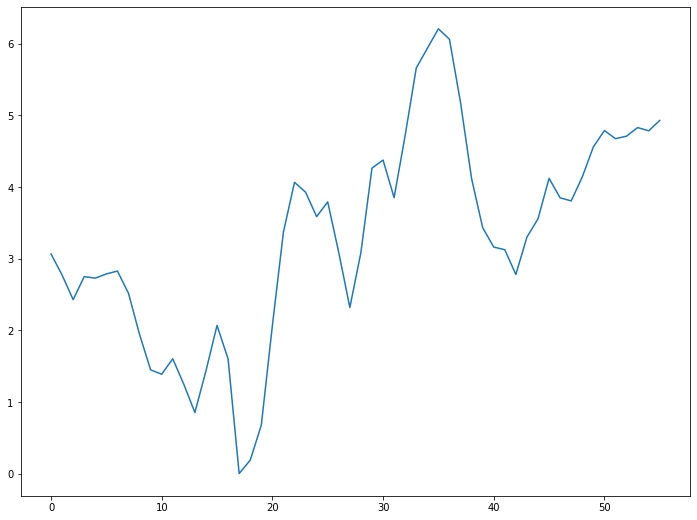

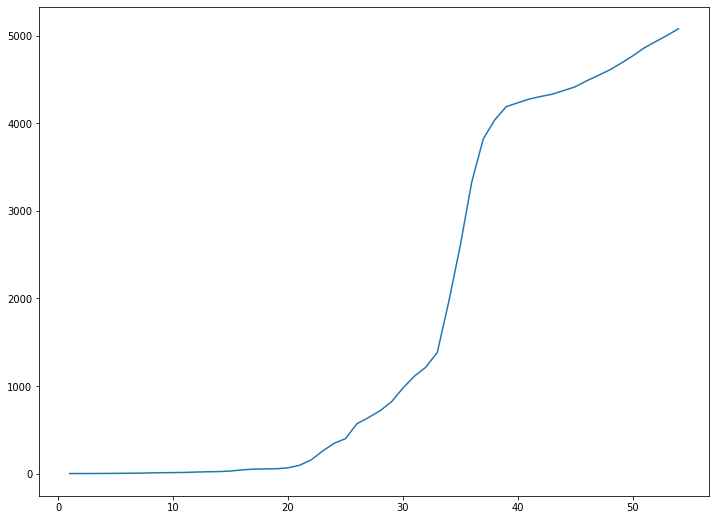

In [362]:
tauVec=sp.linalg.lstsq(QlapRed,bvec)
eLabels=list(map(lambda x: np.max(eIndToPair[x]),Qtargets))
plt.figure(figsize=(12,9))
frq=1e-3 #outputFrequency in ns
plt.plot(-np.log(piVec)-np.min(-np.log(piVec)))
plt.show()
plt.figure(figsize=(12,9))
plt.plot(eLabels,(np.max(tauVec[0])-tauVec[0])*frq)
plt.show()

In [334]:
def is_sorted(l):
    return(all(l[i] <= l[i+1] for i in range(len(l)-1)))

is_sorted(tauVec[0])

False

In [336]:
(tauVec[0][:-1]-tauVec[0][1:])>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [343]:
eLabels=list(map(lambda x: '_'.join(map(str,list(eIndToPair[x]))),Qtargets))

['0_1',
 '1_2',
 '2_3',
 '3_4',
 '4_5',
 '5_6',
 '6_7',
 '7_8',
 '8_9',
 '9_10',
 '10_11',
 '11_12',
 '12_13',
 '13_14',
 '14_15',
 '15_16',
 '16_17',
 '17_18',
 '18_19',
 '19_20',
 '20_21',
 '21_22',
 '22_23',
 '23_24',
 '24_25',
 '25_26',
 '26_27',
 '27_28',
 '28_29',
 '29_30',
 '30_31',
 '31_32',
 '32_33',
 '33_34',
 '34_35',
 '35_36',
 '36_37',
 '37_38',
 '38_39',
 '39_40',
 '40_41',
 '41_42',
 '42_43',
 '43_44',
 '44_45',
 '45_46',
 '46_47',
 '47_48',
 '48_49',
 '49_50',
 '50_51',
 '51_52',
 '52_53',
 '53_54']